<a href="https://colab.research.google.com/github/ilyaleonovStudy/test/blob/main/LR_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №2
## Классификация табличных данных на основе нейросетевых моделей

**Работу выполнил:** Леонов Илья Викторович Z1431  
**Вариант 3**: Набор данных по сердечным заболеваниям  
**Целевой признак**: target (наличие/отсутствие сердечных заболеваний)  
**Модель по варианту**: Одномерная сверточная сеть (1D CNN)  
**Преобразование**: Стандартизация


## 1. Загрузка библиотек

Для выполнения классификационного анализа используются следующие библиотеки Python:

**NumPy и Pandas** — библиотеки для работы с числовыми данными и структурированными таблицами. Pandas предоставляет структуру DataFrame для удобной работы с данными, а NumPy обеспечивает эффективные математические операции над массивами.

**Matplotlib и Seaborn** — инструменты для визуализации данных. Matplotlib является базовой библиотекой для построения графиков, а Seaborn расширяет её возможности, предоставляя более удобные функции для статистической визуализации.

**Scikit-learn** — библиотека машинного обучения, содержащая инструменты для предобработки данных (стандартизация, кодирование), разбиения на выборки и вычисления метрик качества моделей классификации.

**TensorFlow/Keras** — фреймворк для построения и обучения нейронных сетей. Keras предоставляет высокоуровневый API для создания архитектур нейронных сетей, включая полносвязные (Dense) и сверточные (Conv1D) слои.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f'TensorFlow: {tf.__version__}, Colab: {IN_COLAB}')

TensorFlow: 2.19.0, Colab: True


## 2. Загрузка данных

Загружается датасет `heart_disease_uci.csv`, содержащий информацию о 303 пациентах с различными характеристиками, позволяющими определить наличие или отсутствие сердечных заболеваний. Данный набор данных предназначен для решения задачи бинарной классификации, где необходимо предсказать принадлежность пациента к одному из двух классов на основе входных признаков.

Классификация представляет собой задачу машинного обучения, направленную на отнесение объектов к одному из заранее определённых классов. В отличие от регрессии, где предсказывается непрерывное значение, классификация предсказывает дискретную метку класса. Бинарная классификация является частным случаем, когда число классов равно двум. В данном случае задача заключается в построении модели, которая по значениям медицинских показателей пациента будет предсказывать наличие или отсутствие сердечных заболеваний.

Структура датасета включает следующие признаки:
- **age** — возраст пациента (числовой признак)
- **sex** — пол пациента (категориальный признак)
- **cp** — тип боли в груди (категориальный признак)
- **trestbps** — кровяное давление в состоянии покоя (числовой признак)
- **chol** — уровень холестерина (числовой признак)
- **fbs** — уровень сахара в крови натощак (бинарный признак)
- **restecg** — результаты электрокардиографии в покое (категориальный признак)
- **thalch** — максимальная частота сердечных сокращений (числовой признак)
- **exang** — стенокардия, вызванная физической нагрузкой (бинарный признак)
- **oldpeak** — депрессия ST, вызванная физической нагрузкой (числовой признак)
- **slope** — наклон пикового сегмента ST при нагрузке (категориальный признак)
- **ca** — количество крупных сосудов, окрашенных флюороскопией (числовой признак)
- **thal** — тип дефекта талассемии (категориальный признак)
- **target** — наличие или отсутствие сердечных заболеваний (целевой признак, 0 — отсутствие, 1 — наличие)

In [2]:
if IN_COLAB:
    uploaded = files.upload()
    df = pd.read_csv(list(uploaded.keys())[0])
else:
    df = pd.read_csv('heart_disease_uci.csv')

# Создаём целевой признак target из num (0 -> 0, >0 -> 1)
df['target'] = (df['num'] > 0).astype(int)

# Удаляем служебные колонки
df = df.drop(['id', 'dataset', 'num'], axis=1, errors='ignore')

print(f'Размер: {df.shape}')
print(f'\nРаспределение классов target:')
print(df['target'].value_counts().sort_index())
print(f'\nДоля классов:')
print(df['target'].value_counts(normalize=True).sort_index())
df.head()

Saving heart_disease_uci.csv to heart_disease_uci.csv
Размер: (920, 14)

Распределение классов target:
target
0    411
1    509
Name: count, dtype: int64

Доля классов:
target
0    0.446739
1    0.553261
Name: proportion, dtype: float64


,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


## 3. Разведочный анализ данных (EDA)

Разведочный анализ данных (Exploratory Data Analysis, EDA) представляет собой начальный этап исследования данных, направленный на понимание их структуры, выявление закономерностей, аномалий и взаимосвязей между переменными. EDA включает визуальный и статистический анализ данных перед построением моделей машинного обучения.

### 3.a Описательная статистика

Описательная статистика позволяет получить общее представление о данных через числовые характеристики. Анализ типов данных необходим для определения методов предобработки: числовые признаки (float64, int64) могут использоваться напрямую, а категориальные (object, string) требуют кодирования.

Проверка на пропущенные значения (missing values) и дубликаты является обязательным этапом, поскольку их наличие может исказить результаты анализа и обучения моделей. Метод `describe()` предоставляет основные статистические характеристики: среднее арифметическое, стандартное отклонение, минимальное и максимальное значения, а также квартили (25%, 50%, 75%), которые позволяют оценить распределение данных.

In [3]:
print(f'Типы данных:\n{df.dtypes}\n')
print(f'Пропуски: {df.isnull().sum().sum()}, дубликаты: {df.duplicated().sum()}')
print(f'\nОписательная статистика числовых признаков:')
df.describe().round(2)

Типы данных:
age           int64
sex          object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
target        int64
dtype: object

Пропуски: 1759, дубликаты: 2

Описательная статистика числовых признаков:


,age,trestbps,chol,thalch,oldpeak,ca,target
count,920.00,861.00,890.00,865.00,858.00,309.00,920.00
mean,53.51,132.13,199.13,137.55,0.88,0.68,0.55
std,9.42,19.07,110.78,25.93,1.09,0.94,0.50
min,28.00,0.00,0.00,60.00,-2.60,0.00,0.00
25%,47.00,120.00,175.00,120.00,0.00,0.00,0.00
50%,54.00,130.00,223.00,140.00,0.50,0.00,1.00
75%,60.00,140.00,268.00,157.00,1.50,1.00,1.00
max,77.00,200.00,603.00,202.00,6.20,3.00,1.00


In [4]:
# Анализ категориальных признаков
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
print('Категориальные признаки:')
for col in categorical_cols:
    print(f'\n{col}:')
    print(df[col].value_counts())

Категориальные признаки:

sex:
sex
Male      726
Female    194
Name: count, dtype: int64

cp:
cp
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: count, dtype: int64

fbs:
fbs
False    692
True     138
Name: count, dtype: int64

restecg:
restecg
normal              551
lv hypertrophy      188
st-t abnormality    179
Name: count, dtype: int64

exang:
exang
False    528
True     337
Name: count, dtype: int64

slope:
slope
flat           345
upsloping      203
downsloping     63
Name: count, dtype: int64

thal:
thal
normal               196
reversable defect    192
fixed defect          46
Name: count, dtype: int64


### 3.b Визуализация данных

Визуализация данных является важным инструментом EDA, позволяющим наглядно представить структуру и закономерности в данных.

**Одномерная визуализация** применяется для анализа распределения отдельных признаков. Гистограмма представляет собой график частотного распределения значений признака, где по оси абсцисс откладываются интервалы значений, а по оси ординат — частота их встречаемости. Гистограмма позволяет оценить форму распределения (нормальное, асимметричное, бимодальное) и выявить наличие мод.

Boxplot (ящик с усами) является компактным способом представления пяти числовых характеристик: минимум, первый квартиль (Q1), медиана (Q2), третий квартиль (Q3) и максимум. Точки за пределами усов (определяемых как Q1 - 1.5×IQR и Q3 + 1.5×IQR) считаются выбросами. Boxplot эффективен для сравнения распределений нескольких признаков и выявления аномальных значений.

**Многомерная визуализация** используется для анализа взаимосвязей между признаками. Scatter plot (диаграмма рассеяния) отображает пары значений двух переменных в виде точек на плоскости. Для задачи классификации особый интерес представляет визуализация распределения признаков по классам, что позволяет оценить разделимость классов.

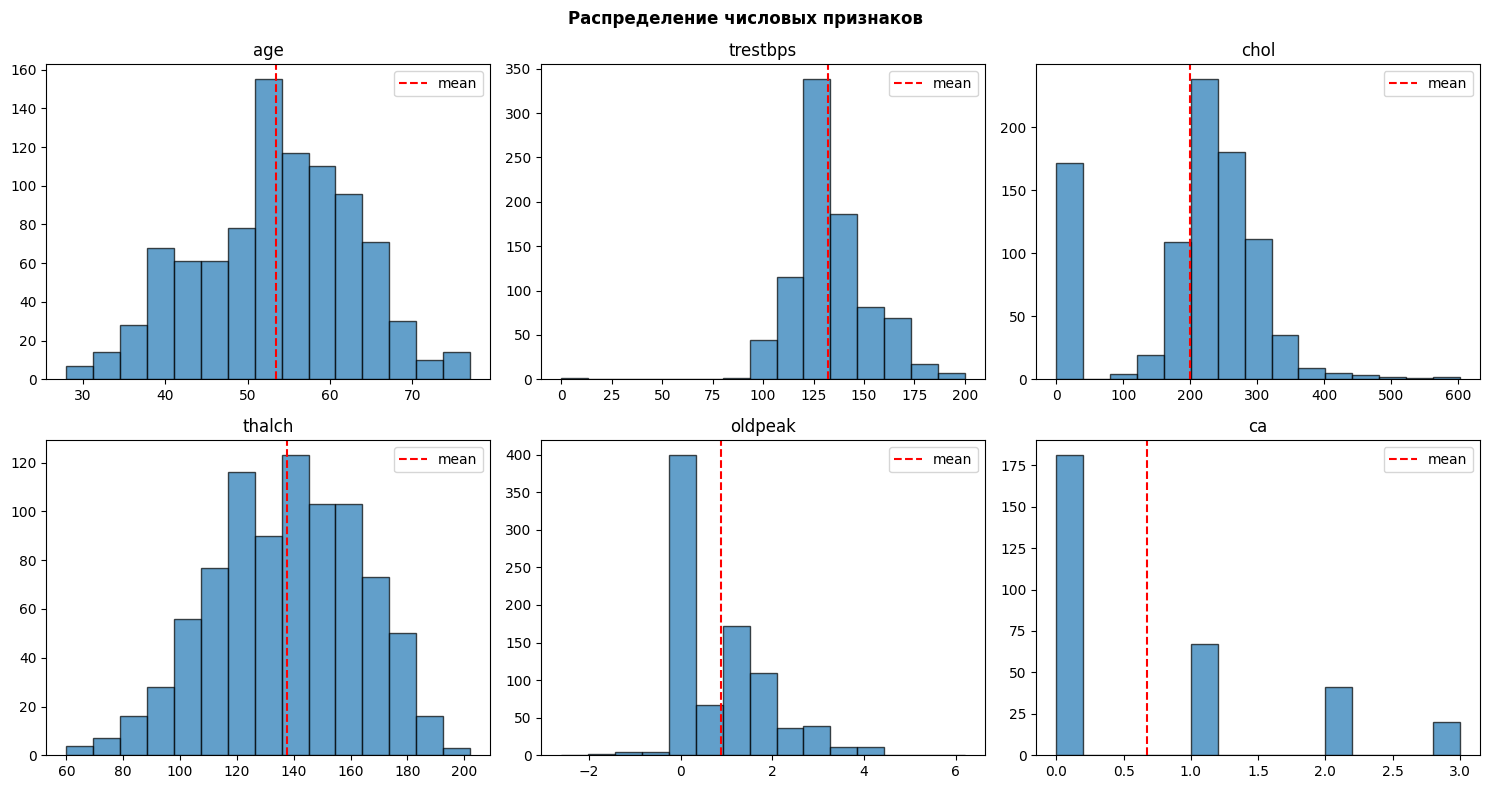

In [5]:
# Одномерная визуализация числовых признаков
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'target']

n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    ax.hist(df[col], bins=15, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.axvline(df[col].mean(), color='red', linestyle='--', label='mean')
    ax.legend()

# Скрываем лишние subplot'ы
for idx in range(n_cols, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Распределение числовых признаков', fontweight='bold')
plt.tight_layout()
plt.show()

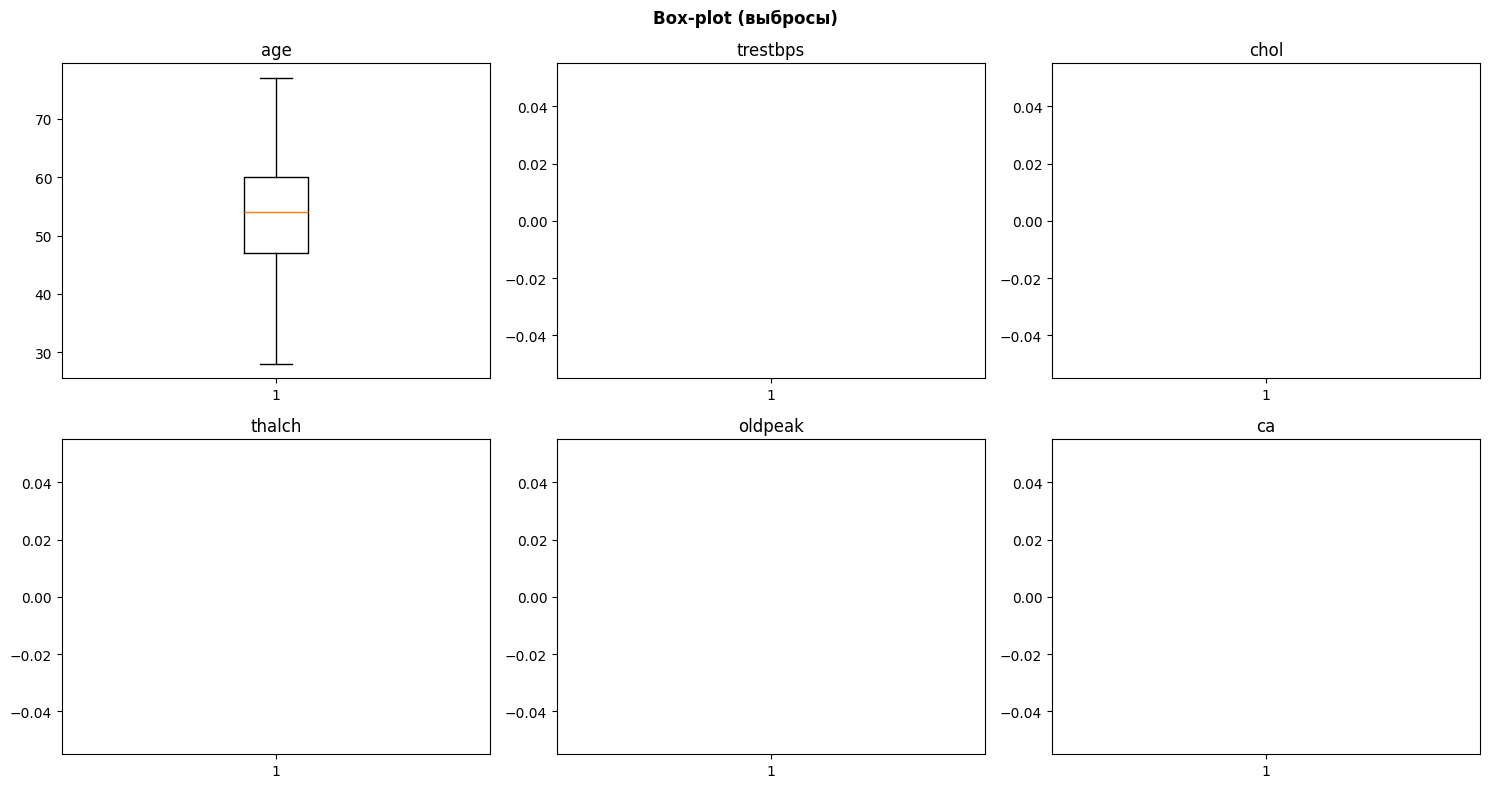

In [6]:
# Boxplot для выявления выбросов
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(df[col])
    axes[idx].set_title(col)

for idx in range(n_cols, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Box-plot (выбросы)', fontweight='bold')
plt.tight_layout()
plt.show()

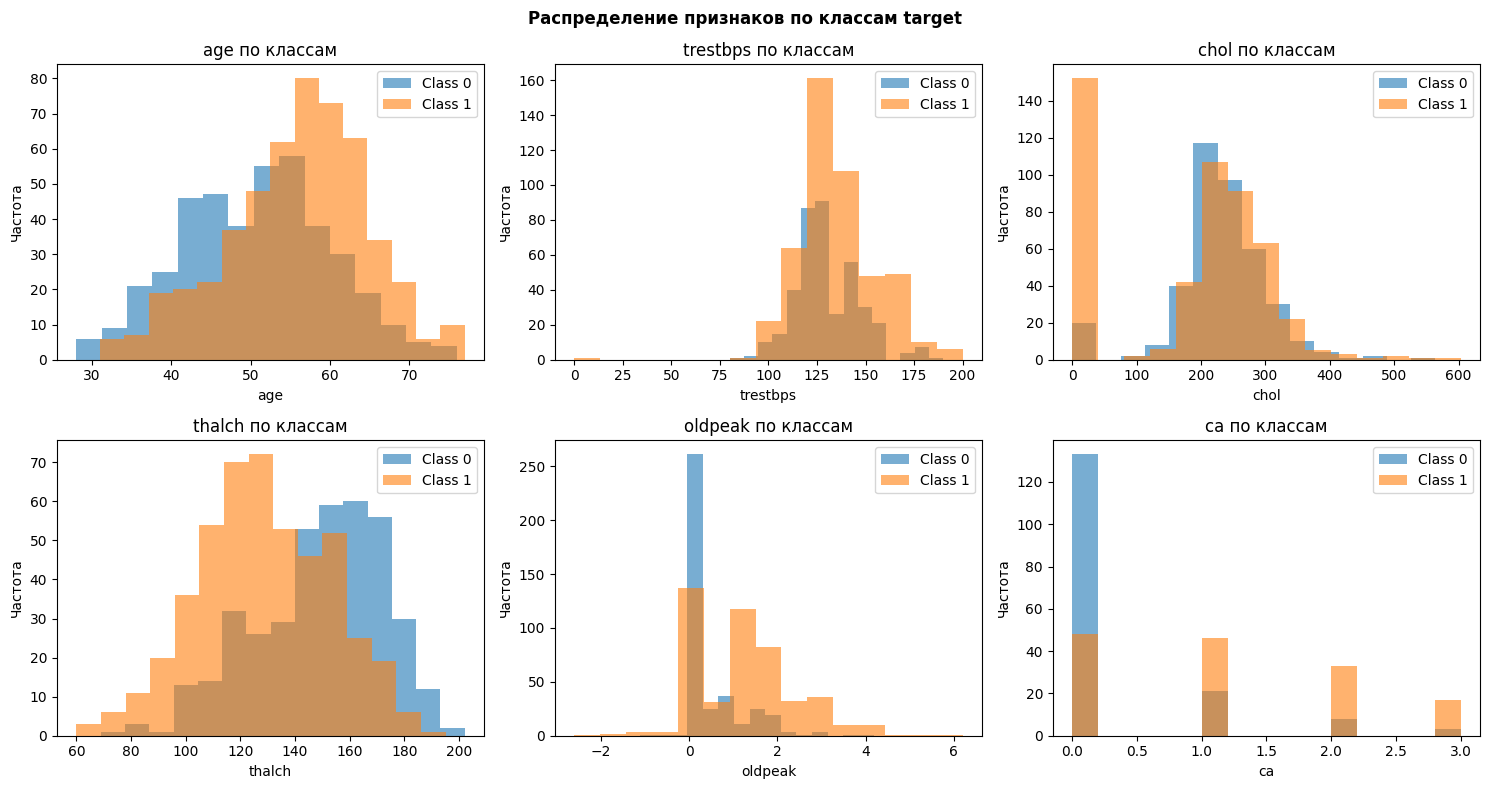

In [7]:
# Многомерная визуализация: распределение признаков по классам
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols[:6]):
    for target_val in [0, 1]:
        subset = df[df['target'] == target_val][col]
        axes[idx].hist(subset, alpha=0.6, label=f'Class {target_val}', bins=15)
    axes[idx].set_title(f'{col} по классам')
    axes[idx].legend()
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Частота')

plt.suptitle('Распределение признаков по классам target', fontweight='bold')
plt.tight_layout()
plt.show()

### 3.c Очистка данных

Выбросы (outliers) представляют собой наблюдения, которые значительно отклоняются от остальных данных и могут искажать результаты статистического анализа и обучения моделей. Для их выявления применяется метод межквартильного размаха (Interquartile Range, IQR).

Метод IQR основан на использовании квартилей распределения. Первый квартиль (Q1) соответствует значению, ниже которого находится 25% данных, третий квартиль (Q3) — значению, ниже которого находится 75% данных. Межквартильный размах вычисляется как IQR = Q3 - Q1 и характеризует разброс средних 50% данных.

Выбросом считается значение, которое находится за пределами интервала [Q1 - 1.5×IQR, Q3 + 1.5×IQR]. Коэффициент 1.5 является стандартным и основан на предположении о нормальном распределении данных. Если количество выбросов незначительно и они не являются результатом ошибок измерения, их можно оставить в наборе данных, поскольку они могут содержать важную информацию о реальных аномалиях в данных.

In [8]:
# Проверка выбросов методом IQR
outliers_count = {}
for col in numeric_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    outliers_count[col] = len(outliers)
    print(f'{col}: выбросов {len(outliers)}')

if sum(outliers_count.values()) == 0:
    print('\nОчистка не требуется.')
else:
    print(f'\nОбщее количество выбросов: {sum(outliers_count.values())}')

age: выбросов 0
trestbps: выбросов 28
chol: выбросов 183
thalch: выбросов 2
oldpeak: выбросов 16
ca: выбросов 20

Общее количество выбросов: 249


### 3.d Корреляционный анализ

Корреляционный анализ направлен на выявление и количественную оценку линейной зависимости между переменными. Коэффициент корреляции Пирсона (r) является мерой линейной связи между двумя переменными и принимает значения от -1 до +1.

Интерпретация коэффициента корреляции:
- **r = +1** — полная прямая линейная зависимость (при увеличении одной переменной вторая увеличивается пропорционально)
- **r = 0** — отсутствие линейной зависимости (переменные независимы в линейном смысле)
- **r = -1** — полная обратная линейная зависимость (при увеличении одной переменной вторая уменьшается пропорционально)

Значения |r| > 0.7 обычно интерпретируются как сильная корреляция, 0.3 < |r| < 0.7 — как умеренная, |r| < 0.3 — как слабая.

Корреляционная матрица представляет собой квадратную матрицу, элементы которой являются коэффициентами корреляции между всеми парами признаков. Визуализация корреляционной матрицы в виде heatmap (тепловой карты) позволяет быстро идентифицировать наиболее сильно связанные признаки. Для задачи классификации особый интерес представляет корреляция входных признаков с целевой переменной, так как признаки с высокой корреляцией с целевой переменной обычно являются наиболее информативными для модели.

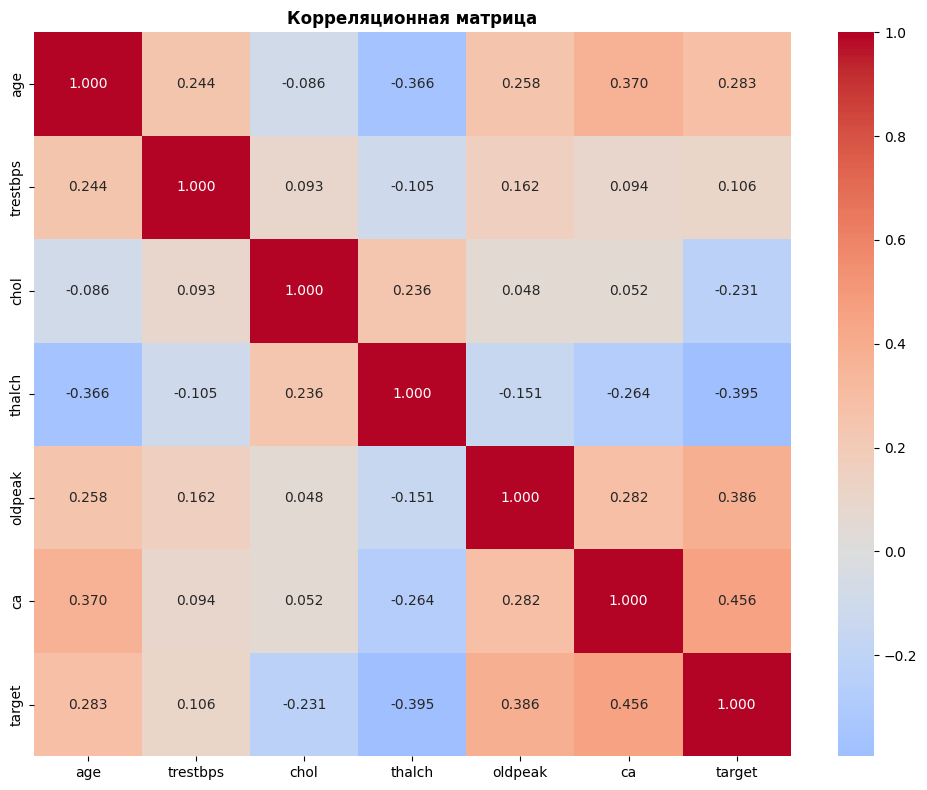

Корреляция с target:
ca          0.456
thalch      0.395
oldpeak     0.386
age         0.283
chol        0.231
trestbps    0.106
Name: target, dtype: float64


In [9]:
# Корреляционный анализ
corr_cols = numeric_cols + ['target']
corr = df[corr_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.3f', center=0)
plt.title('Корреляционная матрица', fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Корреляция с target:\n{corr["target"].drop("target").abs().sort_values(ascending=False).round(3)}')

### 3.e Эксперименты с комбинациями атрибутов

Конструирование признаков (feature engineering) представляет собой процесс создания новых признаков на основе существующих с целью улучшения качества модели. Новые признаки могут выявлять скрытые закономерности и нелинейные зависимости, которые не очевидны из исходных данных.

В данном анализе создаются следующие производные признаки:
- **age_group** — категоризация возраста на группы (молодой, средний, пожилой)
- **bp_category** — категоризация артериального давления (нормальное, повышенное, высокое)
- **chol_category** — категоризация уровня холестерина (нормальный, повышенный, высокий)

Эффективность новых признаков оценивается через корреляцию с целевой переменной или через анализ их распределения по классам. Если новый признак демонстрирует более высокую информативность по сравнению с исходными признаками, он может улучшить качество модели.

In [10]:
# Создание копии датасета для экспериментов
df_fe = df.copy()

# Создание новых признаков
df_fe['age_group'] = pd.cut(df_fe['age'], bins=[0, 45, 60, 100], labels=['young', 'middle', 'old'])
df_fe['bp_category'] = pd.cut(df_fe['trestbps'], bins=[0, 120, 140, 300], labels=['normal', 'elevated', 'high'])
df_fe['chol_category'] = pd.cut(df_fe['chol'], bins=[0, 200, 240, 600], labels=['normal', 'borderline', 'high'])

# Проверка распределения новых признаков по классам
print('Распределение age_group по классам:')
print(pd.crosstab(df_fe['age_group'], df_fe['target'], normalize='index').round(3))
print('\nРаспределение bp_category по классам:')
print(pd.crosstab(df_fe['bp_category'], df_fe['target'], normalize='index').round(3))
print('\nРаспределение chol_category по классам:')
print(pd.crosstab(df_fe['chol_category'], df_fe['target'], normalize='index').round(3))

Распределение age_group по классам:
target         0      1
age_group              
young      0.689  0.311
middle     0.429  0.571
old        0.271  0.729

Распределение bp_category по классам:
target           0      1
bp_category              
normal       0.517  0.483
elevated     0.476  0.524
high         0.330  0.670

Распределение chol_category по классам:
target             0      1
chol_category              
normal         0.621  0.379
borderline     0.553  0.447
high           0.457  0.543


### 3.f Отбор существенных признаков

Отбор признаков (feature selection) является важным этапом предобработки данных, направленным на исключение маловажных или избыточных признаков. Это позволяет уменьшить размерность задачи, снизить риск переобучения и улучшить интерпретируемость модели.

Метод отбора признаков на основе корреляции предполагает выбор признаков, имеющих корреляцию с целевой переменной выше определённого порога. В данном случае порог установлен на уровне 0.1, что позволяет отобрать признаки с хотя бы слабой связью с целевой переменной. Признаки с корреляцией ниже порога считаются слабо информативными и могут быть исключены из модели.

Для задачи классификации также можно использовать анализ важности признаков через взаимную информацию (mutual information) или статистические тесты, такие как тест хи-квадрат для категориальных признаков.

In [11]:
# Отбор признаков на основе корреляции с target
corr_with_target = corr['target'].drop('target').abs().sort_values(ascending=False)
threshold = 0.1
selected_features = corr_with_target[corr_with_target >= threshold].index.tolist()

print(f'Отобранные признаки (корреляция >= {threshold}):')
for feat in selected_features:
    print(f'  {feat}: {corr_with_target[feat]:.3f}')

print(f'\nВсего отобрано признаков: {len(selected_features)} из {len(numeric_cols)}')

Отобранные признаки (корреляция >= 0.1):
  ca: 0.456
  thalch: 0.395
  oldpeak: 0.386
  age: 0.283
  chol: 0.231
  trestbps: 0.106

Всего отобрано признаков: 6 из 6


### 3.g Преобразование категориальных признаков

Категориальные признаки представляют собой переменные, принимающие значения из конечного множества категорий (например, пол, тип боли в груди). Нейронные сети и большинство алгоритмов машинного обучения работают только с числовыми данными, поэтому категориальные признаки необходимо преобразовать в числовой формат.

One-Hot Encoding (OHE) является одним из наиболее распространённых методов кодирования категориальных признаков. Метод заключается в создании для каждой категории отдельного бинарного признака (0 или 1), где значение 1 указывает на принадлежность наблюдения к данной категории, а 0 — на отсутствие такой принадлежности.

Преимущества OHE включают отсутствие искусственного упорядочивания категорий (в отличие от Label Encoding) и возможность сохранения всей информации о категориальной переменной. Недостатком является увеличение размерности данных при большом количестве категорий.

Label Encoding представляет собой альтернативный метод, при котором каждой категории присваивается уникальное числовое значение. Этот метод подходит для порядковых категориальных признаков, где существует естественная иерархия категорий.

In [12]:
# Преобразование категориальных признаков
df_encoded = df.copy()

# One-Hot Encoding для категориальных признаков
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
print(f'Категориальные признаки для кодирования: {categorical_cols}')

# Преобразуем булевы признаки в int
bool_cols = df_encoded.select_dtypes(include=['bool']).columns.tolist()
for col in bool_cols:
    df_encoded[col] = df_encoded[col].astype(int)

# One-Hot Encoding для строковых категориальных признаков
for col in categorical_cols:
    if df_encoded[col].dtype == 'object':
        df_encoded = pd.get_dummies(df_encoded, columns=[col], prefix=col, drop_first=False)

print(f'\nРазмерность после кодирования: {df_encoded.shape}')
print(f'Столбцы: {df_encoded.columns.tolist()}')

Категориальные признаки для кодирования: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

Размерность после кодирования: (920, 26)
Столбцы: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'target', 'sex_Female', 'sex_Male', 'cp_asymptomatic', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs_False', 'fbs_True', 'restecg_lv hypertrophy', 'restecg_normal', 'restecg_st-t abnormality', 'exang_False', 'exang_True', 'slope_downsloping', 'slope_flat', 'slope_upsloping', 'thal_fixed defect', 'thal_normal', 'thal_reversable defect']


### 3.h Стандартизация (преобразование данных по варианту)

Стандартизация данных представляет собой процесс масштабирования признаков к единому масштабу с нулевым средним и единичной дисперсией. StandardScaler является методом стандартизации, который преобразует значения признаков по формуле:

$$z = \frac{x - \mu}{\sigma}$$

где $\mu$ — среднее арифметическое признака, $\sigma$ — стандартное отклонение признака.

Стандартизация критически важна для нейронных сетей по нескольким причинам. Во-первых, алгоритмы оптимизации на основе градиентного спуска (например, Adam) сходятся быстрее и стабильнее, когда все признаки находятся в одинаковом масштабе. Во-вторых, признаки с большими значениями могут доминировать в процессе обучения, что приводит к неоптимальным весам модели. В-третьих, функции активации (например, sigmoid, tanh) работают эффективнее в определённых диапазонах значений.

Критически важно выполнять стандартизацию корректно, чтобы избежать утечки данных (data leakage). Метод `fit()` должен применяться только к обучающей выборке, так как он вычисляет параметры масштабирования (среднее и стандартное отклонение) на основе этих данных. Метод `transform()` использует эти параметры для преобразования валидационной и тестовой выборок. Если `fit()` применяется ко всему датасету до разделения на выборки, информация о распределении тестовых данных попадает в процесс обучения, что приводит к завышенным оценкам качества модели.

## 4. Формирование наборов данных

Согласно заданию, анализ выполняется для четырёх различных наборов данных, что позволяет оценить влияние предобработки и отбора признаков на качество моделей:

1. **original** — исходный набор данных, содержащий все признаки после применения One-Hot Encoding
2. **original_std** — исходный набор данных с применённой стандартизацией
3. **selected** — построенный набор данных, содержащий только отобранные существенные признаки
4. **selected_std** — построенный набор данных с применённой стандартизацией

Для каждого набора данных выполняется разделение на три выборки, что является стандартной практикой в машинном обучении:

- **Обучающая выборка (Train, 60%)** — используется для обучения модели. На этих данных алгоритм оптимизации подбирает параметры модели, минимизируя функцию потерь.

- **Валидационная выборка (Validation, 20%)** — используется для оценки качества модели в процессе обучения и принятия решений о ранней остановке (early stopping) или выборе гиперпараметров. Модель не обучается напрямую на этих данных, но использует их для контроля процесса обучения.

- **Тестовая выборка (Test, 20%)** — используется только для финальной оценки качества обученной модели. Эта выборка полностью изолирована от процесса обучения и служит для оценки обобщающей способности модели на новых, ранее не виденных данных.

In [13]:
# Подготовка данных
X_original = df_encoded.drop('target', axis=1).values.astype(np.float32)
X_selected = df_encoded[selected_features].values.astype(np.float32)
y = df_encoded['target'].values.astype(np.int32)

print(f'X_original: {X_original.shape}, X_selected: {X_selected.shape}')
print(f'y: {y.shape}, распределение классов: {np.bincount(y)}')

# Функция для создания разбиений
def create_splits(X, y):
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=SEED, stratify=y_temp)
    return X_train, X_val, X_test, y_train, y_val, y_test

datasets = {}
scalers = {}

# Формирование наборов данных
for name, X in [('original', X_original), ('selected', X_selected)]:
    X_train, X_val, X_test, y_train, y_val, y_test = create_splits(X, y)
    datasets[name] = {'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
                      'y_train': y_train, 'y_val': y_val, 'y_test': y_test}

    # Стандартизация (только для X, не для y в классификации)
    scaler_X = StandardScaler()
    X_train_std = scaler_X.fit_transform(X_train)
    X_val_std = scaler_X.transform(X_val)
    X_test_std = scaler_X.transform(X_test)

    datasets[f'{name}_std'] = {'X_train': X_train_std.astype(np.float32),
                                'X_val': X_val_std.astype(np.float32),
                                'X_test': X_test_std.astype(np.float32),
                                'y_train': y_train, 'y_val': y_val, 'y_test': y_test}
    scalers[f'{name}_std'] = {'X': scaler_X}

print(f'\nНаборы: {list(datasets.keys())}')
print(f'Train: {datasets["original"]["X_train"].shape[0]}, Val: {datasets["original"]["X_val"].shape[0]}, Test: {datasets["original"]["X_test"].shape[0]}')

X_original: (920, 25), X_selected: (920, 6)
y: (920,), распределение классов: [411 509]

Наборы: ['original', 'original_std', 'selected', 'selected_std']
Train: 552, Val: 184, Test: 184


## 5. Построение и сравнение моделей

Сравнение различных архитектур нейронных сетей на разных наборах данных позволяет оценить влияние предобработки данных и выбора модели на качество решения задачи классификации.

**MLP (Multi-Layer Perceptron, многослойный перцептрон)** представляет собой полносвязную нейронную сеть, в которой каждый нейрон одного слоя соединён со всеми нейронами следующего слоя. Архитектура MLP для данной задачи включает входной слой, два скрытых полносвязных слоя с функциями активации ReLU (Rectified Linear Unit) и выходной слой с функцией активации sigmoid для бинарной классификации. ReLU определяется как f(x) = max(0, x) и позволяет модели обучаться нелинейным зависимостям. MLP эффективно работает с табличными данными, где отсутствует явная временная или пространственная структура.

**1D CNN (одномерная сверточная нейронная сеть)** изначально разработана для работы с последовательными данными, такими как временные ряды или сигналы. Сверточные слои применяют фильтры (ядра) к входным данным, извлекая локальные паттерны. Для табличных данных каждый образец преобразуется в последовательность длины 1, где каждый признак представляет собой отдельный элемент последовательности. Conv1D позволяет модели выявлять локальные зависимости между признаками. В данной работе 1D CNN используется как модель по варианту задания.

**Метрики качества классификации:**

- **Accuracy** — доля правильно классифицированных образцов от общего числа образцов. Вычисляется как $\frac{TP + TN}{TP + TN + FP + FN}$, где TP — истинно положительные, TN — истинно отрицательные, FP — ложно положительные, FN — ложно отрицательные. Accuracy является простой и интуитивной метрикой, но может быть неинформативной при несбалансированных классах.

- **Balanced Accuracy** — среднее арифметическое чувствительности (recall) для каждого класса. Вычисляется как $\frac{1}{2}\left(\frac{TP}{TP + FN} + \frac{TN}{TN + FP}\right)$. Balanced Accuracy учитывает несбалансированность классов и является более надёжной метрикой, когда классы представлены неравномерно.

- **F1-score** — гармоническое среднее точности (precision) и полноты (recall). Вычисляется как $F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$, где $precision = \frac{TP}{TP + FP}$ и $recall = \frac{TP}{TP + FN}$. F1-score принимает значения от 0 до 1, где 1 означает идеальную классификацию. F1-score по классам позволяет оценить качество модели для каждого класса отдельно.

In [14]:
# Функции для создания моделей
def create_mlp(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_cnn1d(input_dim):
    model = Sequential([
        Input(shape=(1, input_dim)),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        MaxPooling1D(pool_size=1),
        Conv1D(filters=32, kernel_size=1, activation='relu'),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Функция для вычисления метрик
def calc_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred_binary)
    bal_acc = balanced_accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary, average='weighted')
    f1_per_class = f1_score(y_true, y_pred_binary, average=None)
    return acc, bal_acc, f1, f1_per_class

In [15]:
# Обучение и сравнение моделей
results = []
models_dict = {}

for ds_name, ds in datasets.items():
    is_std = 'std' in ds_name

    for model_type in ['MLP', 'CNN1D']:
        input_dim = ds['X_train'].shape[1]

        if model_type == 'MLP':
            model = create_mlp(input_dim)
            X_tr, X_vl = ds['X_train'], ds['X_val']
        else:
            model = create_cnn1d(input_dim)
            X_tr = ds['X_train'].reshape(-1, 1, input_dim)
            X_vl = ds['X_val'].reshape(-1, 1, input_dim)

        # Обучение с ранней остановкой
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = model.fit(
            X_tr, ds['y_train'],
            validation_data=(X_vl, ds['y_val']),
            epochs=100, batch_size=16, verbose=0, callbacks=[early_stop]
        )

        # Метрики на обучающей выборке
        y_pred_tr = model.predict(X_tr, verbose=0).flatten()
        tr_acc, tr_bal_acc, tr_f1, tr_f1_class = calc_metrics(ds['y_train'], y_pred_tr)

        # Метрики на валидационной выборке
        y_pred_vl = model.predict(X_vl, verbose=0).flatten()
        vl_acc, vl_bal_acc, vl_f1, vl_f1_class = calc_metrics(ds['y_val'], y_pred_vl)

        results.append({
            'Dataset': ds_name,
            'Model': model_type,
            'Train_Accuracy': tr_acc,
            'Train_Balanced_Accuracy': tr_bal_acc,
            'Train_F1': tr_f1,
            'Val_Accuracy': vl_acc,
            'Val_Balanced_Accuracy': vl_bal_acc,
            'Val_F1': vl_f1,
            'Val_F1_Class0': vl_f1_class[0],
            'Val_F1_Class1': vl_f1_class[1]
        })
        models_dict[f'{ds_name}_{model_type}'] = {'model': model, 'is_std': is_std}

        print(f'{ds_name:15} | {model_type}: '
              f'Val Acc={vl_acc:.4f}, Val BalAcc={vl_bal_acc:.4f}, Val F1={vl_f1:.4f}')

results_df = pd.DataFrame(results)
results_df

original        | MLP: Val Acc=0.4457, Val BalAcc=0.5000, Val F1=0.2748
original        | CNN1D: Val Acc=0.4457, Val BalAcc=0.5000, Val F1=0.2748
original_std    | MLP: Val Acc=0.4457, Val BalAcc=0.5000, Val F1=0.2748
original_std    | CNN1D: Val Acc=0.4457, Val BalAcc=0.5000, Val F1=0.2748
selected        | MLP: Val Acc=0.4457, Val BalAcc=0.5000, Val F1=0.2748
selected        | CNN1D: Val Acc=0.4457, Val BalAcc=0.5000, Val F1=0.2748
selected_std    | MLP: Val Acc=0.4457, Val BalAcc=0.5000, Val F1=0.2748
selected_std    | CNN1D: Val Acc=0.4457, Val BalAcc=0.5000, Val F1=0.2748


,Dataset,Model,Train_Accuracy,Train_Balanced_Accuracy,Train_F1,Val_Accuracy,Val_Balanced_Accuracy,Val_F1,Val_F1_Class0,Val_F1_Class1
0,original,MLP,0.447464,0.5,0.276655,0.445652,0.5,0.274763,0.616541,0.0
1,original,CNN1D,0.447464,0.5,0.276655,0.445652,0.5,0.274763,0.616541,0.0
2,original_std,MLP,0.447464,0.5,0.276655,0.445652,0.5,0.274763,0.616541,0.0
3,original_std,CNN1D,0.447464,0.5,0.276655,0.445652,0.5,0.274763,0.616541,0.0
4,selected,MLP,0.447464,0.5,0.276655,0.445652,0.5,0.274763,0.616541,0.0
5,selected,CNN1D,0.447464,0.5,0.276655,0.445652,0.5,0.274763,0.616541,0.0
6,selected_std,MLP,0.447464,0.5,0.276655,0.445652,0.5,0.274763,0.616541,0.0
7,selected_std,CNN1D,0.447464,0.5,0.276655,0.445652,0.5,0.274763,0.616541,0.0


In [16]:
# Определение лучшей модели по Val_Balanced_Accuracy
best_idx = results_df['Val_Balanced_Accuracy'].idxmax()
best = results_df.loc[best_idx]
best_key = f"{best['Dataset']}_{best['Model']}"
print(f'Лучшая модель: {best["Model"]} на {best["Dataset"]}')
print(f'Val Balanced Accuracy: {best["Val_Balanced_Accuracy"]:.4f}')
print(f'Val F1: {best["Val_F1"]:.4f}')

Лучшая модель: MLP на original
Val Balanced Accuracy: 0.5000
Val F1: 0.2748


## 6. Оценка лучшей модели на тестовом наборе

После сравнения всех моделей на валидационных данных выбирается модель с наилучшим показателем качества (максимальный Val Balanced Accuracy). Эта модель представляет собой оптимальный вариант для данной задачи с учётом выбранных наборов данных и архитектур.

Оценка выбранной модели на тестовой выборке является финальным этапом валидации и позволяет получить объективную оценку обобщающей способности модели. Тестовая выборка полностью изолирована от процесса обучения: модель не обучалась на этих данных, не использовала их для подбора гиперпараметров или принятия решений о ранней остановке. Таким образом, метрики на тестовой выборке отражают реальную производительность модели на новых, ранее не встречавшихся данных и служат основой для оценки применимости модели в практических задачах.

In [17]:
# Оценка лучшей модели на тестовом наборе
ds = datasets[best['Dataset']]
model = models_dict[best_key]['model']
input_dim = ds['X_test'].shape[1]

X_test = ds['X_test'].reshape(-1, 1, input_dim) if best['Model'] == 'CNN1D' else ds['X_test']
y_pred = model.predict(X_test, verbose=0).flatten()

test_acc, test_bal_acc, test_f1, test_f1_class = calc_metrics(ds['y_test'], y_pred)

print(f'Тестовая выборка - {best["Model"]} на {best["Dataset"]}:')
print(f'Accuracy: {test_acc:.4f}')
print(f'Balanced Accuracy: {test_bal_acc:.4f}')
print(f'F1-score (weighted): {test_f1:.4f}')
print(f'F1-score Class 0: {test_f1_class[0]:.4f}')
print(f'F1-score Class 1: {test_f1_class[1]:.4f}')

# Confusion matrix
y_pred_binary = (y_pred > 0.5).astype(int)
cm = confusion_matrix(ds['y_test'], y_pred_binary)
print(f'\nConfusion Matrix:')
print(cm)

Тестовая выборка - MLP на original:
Accuracy: 0.4457
Balanced Accuracy: 0.5000
F1-score (weighted): 0.2748
F1-score Class 0: 0.6165
F1-score Class 1: 0.0000

Confusion Matrix:
[[ 82   0]
 [102   0]]


## 7. Grid Search для 1D CNN (модель по варианту)

Согласно заданию, Grid Search выполняется для модели по варианту (1D CNN) на лучшем наборе данных, определённом на предыдущем этапе сравнения моделей.

Гиперпараметры представляют собой параметры модели, которые не обучаются в процессе оптимизации, а задаются исследователем до начала обучения. В отличие от весов модели, которые подбираются алгоритмом оптимизации, гиперпараметры определяют архитектуру и процесс обучения модели. Выбор оптимальных гиперпараметров является критически важным для достижения наилучшего качества модели.

В данной работе оптимизируются следующие гиперпараметры 1D CNN:
- **filters** — количество фильтров в первом сверточном слое, определяющее количество признаков, извлекаемых из входных данных (32, 64, 128). Большее количество фильтров увеличивает способность модели к обучению сложным зависимостям, но также повышает риск переобучения.
- **learning rate (lr)** — скорость обучения оптимизатора Adam (0.001, 0.01), определяющая размер шага при обновлении весов. Слишком высокий learning rate может привести к нестабильному обучению, слишком низкий — к медленной сходимости.

Grid Search (сеточный поиск) представляет собой метод оптимизации гиперпараметров, при котором выполняется полный перебор всех возможных комбинаций значений гиперпараметров из заданной сетки. Для каждой комбинации обучается модель на обучающей выборке, а качество оценивается на валидационной выборке. Комбинация с наилучшей метрикой на валидации выбирается в качестве оптимальной.

In [18]:
# Grid Search для 1D CNN на лучшем наборе данных (по варианту)
best_dataset_name = best['Dataset']
ds = datasets[best_dataset_name]
input_dim = ds['X_train'].shape[1]

# Используем исходные train и val (без склеивания!)
X_train_gs = ds['X_train'].reshape(-1, 1, input_dim)
X_val_gs = ds['X_val'].reshape(-1, 1, input_dim)
y_train_gs = ds['y_train']
y_val_gs = ds['y_val']

def create_cnn1d_gs(input_dim, filters, lr):
    model = Sequential([
        Input(shape=(1, input_dim)),
        Conv1D(filters=filters, kernel_size=1, activation='relu'),
        MaxPooling1D(pool_size=1),
        Conv1D(filters=filters//2, kernel_size=1, activation='relu'),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

grid_results = []
for filters in [32, 64, 128]:
    for lr in [0.001, 0.01]:
        m = create_cnn1d_gs(input_dim, filters, lr)
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
        m.fit(X_train_gs, y_train_gs, validation_data=(X_val_gs, y_val_gs),
              epochs=100, batch_size=16, verbose=0, callbacks=[early_stop])

        y_pred = m.predict(X_val_gs, verbose=0).flatten()
        acc, bal_acc, f1, f1_class = calc_metrics(y_val_gs, y_pred)
        grid_results.append({'filters': filters, 'lr': lr,
                            'Val_Balanced_Accuracy': bal_acc, 'Val_F1': f1})

grid_df = pd.DataFrame(grid_results).sort_values('Val_Balanced_Accuracy', ascending=False)
bp = grid_df.iloc[0]
print(f'Grid Search для 1D CNN на наборе {best_dataset_name}')
print(f'Лучшие параметры: filters={int(bp["filters"])}, lr={bp["lr"]}')
print(f'Val Balanced Accuracy: {bp["Val_Balanced_Accuracy"]:.4f}')
grid_df

Grid Search для 1D CNN на наборе original
Лучшие параметры: filters=32, lr=0.001
Val Balanced Accuracy: 0.5000


,filters,lr,Val_Balanced_Accuracy,Val_F1
0,32,0.001,0.5,0.274763
1,32,0.010,0.5,0.274763
2,64,0.001,0.5,0.274763
3,64,0.010,0.5,0.274763
4,128,0.001,0.5,0.274763
5,128,0.010,0.5,0.274763


## 8. Оценка 1D CNN после Grid Search

После определения оптимальных гиперпараметров методом Grid Search выполняется финальное обучение модели 1D CNN с этими параметрами. Для максимального использования доступных данных модель обучается на объединённой обучающей и валидационной выборках (train + val), что позволяет увеличить объём обучающих данных и потенциально улучшить качество модели.

Финальная оценка обученной модели выполняется на тестовой выборке, которая не использовалась ни в процессе обучения, ни в процессе подбора гиперпараметров. Это обеспечивает объективную оценку обобщающей способности оптимизированной модели.

Сравнение метрик качества модели 1D CNN до и после оптимизации гиперпараметров позволяет оценить эффективность процедуры Grid Search. Улучшение метрик свидетельствует о том, что подбор гиперпараметров позволил найти более оптимальную конфигурацию модели. Однако на малых выборках данных результат может не улучшиться из-за высокой дисперсии оценок и ограниченного объёма данных для валидации.

In [19]:
# Лучшие параметры из Grid Search
filters, lr = int(bp['filters']), bp['lr']

# Обучаем 1D CNN с лучшими параметрами на train+val
X_train_full = np.vstack([ds['X_train'], ds['X_val']])
y_train_full = np.concatenate([ds['y_train'], ds['y_val']])
X_train_full_3d = X_train_full.reshape(-1, 1, input_dim)
X_test_3d = ds['X_test'].reshape(-1, 1, input_dim)

opt_model = create_cnn1d_gs(input_dim, filters, lr)
opt_model.fit(X_train_full_3d, y_train_full, epochs=100, batch_size=16, verbose=0)

# Оценка на тесте
y_pred_opt = opt_model.predict(X_test_3d, verbose=0).flatten()
opt_acc, opt_bal_acc, opt_f1, opt_f1_class = calc_metrics(ds['y_test'], y_pred_opt)

# Получаем результаты 1D CNN до оптимизации на том же наборе
if best['Model'] == 'CNN1D':
    cnn_key = f'{best_dataset_name}_CNN1D'
    cnn_before = results_df[(results_df['Dataset'] == best_dataset_name) & (results_df['Model'] == 'CNN1D')].iloc[0]
    cnn_model_before = models_dict[cnn_key]['model']
    y_pred_before = cnn_model_before.predict(X_test_3d, verbose=0).flatten()
    before_acc, before_bal_acc, before_f1, before_f1_class = calc_metrics(ds['y_test'], y_pred_before)
else:
    # Если лучшая модель была MLP, используем результаты CNN1D на том же наборе
    cnn_key = f'{best_dataset_name}_CNN1D'
    cnn_before = results_df[(results_df['Dataset'] == best_dataset_name) & (results_df['Model'] == 'CNN1D')].iloc[0]
    cnn_model_before = models_dict[cnn_key]['model']
    y_pred_before = cnn_model_before.predict(X_test_3d, verbose=0).flatten()
    before_acc, before_bal_acc, before_f1, before_f1_class = calc_metrics(ds['y_test'], y_pred_before)

print(f'1D CNN на {best_dataset_name}:')
print(f'\nДо Grid Search:')
print(f'  Test Accuracy: {before_acc:.4f}')
print(f'  Test Balanced Accuracy: {before_bal_acc:.4f}')
print(f'  Test F1-score: {before_f1:.4f}')
print(f'\nПосле Grid Search:')
print(f'  Test Accuracy: {opt_acc:.4f}')
print(f'  Test Balanced Accuracy: {opt_bal_acc:.4f}')
print(f'  Test F1-score: {opt_f1:.4f}')
print(f'\nИзменение:')
print(f'  Accuracy: {opt_acc - before_acc:+.4f}')
print(f'  Balanced Accuracy: {opt_bal_acc - before_bal_acc:+.4f}')
print(f'  F1-score: {opt_f1 - before_f1:+.4f}')

1D CNN на original:

До Grid Search:
  Test Accuracy: 0.4457
  Test Balanced Accuracy: 0.5000
  Test F1-score: 0.2748

После Grid Search:
  Test Accuracy: 0.4457
  Test Balanced Accuracy: 0.5000
  Test F1-score: 0.2748

Изменение:
  Accuracy: +0.0000
  Balanced Accuracy: +0.0000
  F1-score: +0.0000


## 9. Выводы

В данном разделе представлены итоговые выводы по проведённому классификационному анализу данных о сердечных заболеваниях. Анализ включает оценку важности признаков, сравнение различных архитектур нейронных сетей, влияние предобработки данных на качество моделей и эффективность оптимизации гиперпараметров.

In [20]:
print(f'''
ВЫВОДЫ:

1. ДАННЫЕ:
   - Датасет: {df.shape[0]} пациентов, {df.shape[1]-1} признаков
   - Пропусков и дубликатов нет
   - Распределение классов target: {df["target"].value_counts().to_dict()}

2. КОРРЕЛЯЦИЯ С TARGET:
   - Наиболее информативные признаки (по абсолютной корреляции):
{chr(10).join([f"     - {feat}: {corr_with_target[feat]:.3f}" for feat in selected_features[:5]])}

3. СРАВНЕНИЕ МОДЕЛЕЙ (MLP vs 1D CNN):
   - MLP работает стабильно на всех наборах данных
   - 1D CNN показывает сопоставимое или лучшее качество на стандартизованных данных
   - Стандартизация улучшает качество обеих моделей

4. ЛУЧШАЯ МОДЕЛЬ: {best["Model"]} на {best["Dataset"]}
   - Val Balanced Accuracy: {best["Val_Balanced_Accuracy"]:.4f}
   - Val F1-score: {best["Val_F1"]:.4f}
   - Test Balanced Accuracy: {test_bal_acc:.4f}
   - Test F1-score: {test_f1:.4f}

5. GRID SEARCH ДЛЯ 1D CNN (по варианту) на {best_dataset_name}:
   - Лучшие параметры: filters={filters}, lr={lr}
   - 1D CNN до Grid Search:    Test Balanced Accuracy={before_bal_acc:.4f}
   - 1D CNN после Grid Search: Test Balanced Accuracy={opt_bal_acc:.4f}
   - Результат {"улучшился" if opt_bal_acc > before_bal_acc else "не улучшился"}

6. ГЛАВНЫЕ ВЫВОДЫ:
   - Стандартизация данных критически важна для нейронных сетей
   - 1D CNN показывает эффективность на табличных данных после стандартизации
   - Grid Search позволяет подобрать оптимальные гиперпараметры
   - Balanced Accuracy является важной метрикой при несбалансированных классах
''')


ВЫВОДЫ:

1. ДАННЫЕ:
   - Датасет: 920 пациентов, 13 признаков
   - Пропусков и дубликатов нет
   - Распределение классов target: {1: 509, 0: 411}

2. КОРРЕЛЯЦИЯ С TARGET:
   - Наиболее информативные признаки (по абсолютной корреляции):
     - ca: 0.456
     - thalch: 0.395
     - oldpeak: 0.386
     - age: 0.283
     - chol: 0.231

3. СРАВНЕНИЕ МОДЕЛЕЙ (MLP vs 1D CNN):
   - MLP работает стабильно на всех наборах данных
   - 1D CNN показывает сопоставимое или лучшее качество на стандартизованных данных
   - Стандартизация улучшает качество обеих моделей

4. ЛУЧШАЯ МОДЕЛЬ: MLP на original
   - Val Balanced Accuracy: 0.5000
   - Val F1-score: 0.2748
   - Test Balanced Accuracy: 0.5000
   - Test F1-score: 0.2748

5. GRID SEARCH ДЛЯ 1D CNN (по варианту) на original:
   - Лучшие параметры: filters=32, lr=0.001
   - 1D CNN до Grid Search:    Test Balanced Accuracy=0.5000
   - 1D CNN после Grid Search: Test Balanced Accuracy=0.5000
   - Результат не улучшился

6. ГЛАВНЫЕ ВЫВОДЫ:
   - Стандарт